# Download The Dataset & YOLOv5

In [2]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="NvAT2Dgtb4qUsl8BPPbr")
project = rf.workspace("alex-eagles-2").project("suas-shape-detection-2")
version = project.version(2)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.2 MB/s eta 0:00:00eta 0:00:01
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to suas-shape-detection-2-2 in yolov5pytorch:: 100%|██████████| 14412/14412 [00:03<00:00, 4502.97it/s]


In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16965, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 16965 (delta 79), reused 99 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16965/16965), 15.71 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (11612/11612), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.0/874.0 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely

# Check The Dataset

In [3]:
# define the location of the dataset, and see the files inside it

dataset_path = dataset.location

print(dataset_path)
!ls {dataset_path}

/kaggle/working/suas-shape-detection-2-2
README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


In [4]:
# view info about the data from the YAML file

import yaml
import os

yaml_path = os.path.join(dataset_path, "data.yaml")

with open(yaml_path, "r") as f:
    yaml_data = yaml.safe_load(f)
    
print(f"Number of classes: {yaml_data['nc']}")
print("Class names:", yaml_data['names'])

Number of classes: 8
Class names: ['circle', 'cross', 'pentagon', 'quarter circle', 'rectangle', 'semicircle', 'star', 'triangle']


In [5]:
import wandb

wandb.login(key='af0f7e70b70e201ac7a935fd898d8796564ce5e5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Augment The Data

In [6]:
import os
import cv2
import albumentations as A
import numpy as np
import shutil

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Paths to images and labels
images_path = '/kaggle/working/suas-shape-detection-2-2/train/images'
labels_path = '/kaggle/working/suas-shape-detection-2-2/train/labels'
augmented_images_path = '/kaggle/working/suas-shape-detection-2-2/augmented/images'
augmented_labels_path = '/kaggle/working/suas-shape-detection-2-2/augmented/labels'

# Create folders if they do not exist
os.makedirs(augmented_images_path, exist_ok=True)
os.makedirs(augmented_labels_path, exist_ok=True)

# Iterate over the dataset
for img_file in os.listdir(images_path):
    if img_file.endswith('.jpg'):
        file_name = img_file[:-4]
        
        # Load image
        img = cv2.imread(os.path.join(images_path, img_file))

        # Load corresponding bounding boxes
        bboxes = []
        class_labels = []
        with open(os.path.join(labels_path, file_name + '.txt'), 'r') as label_file:
            for line in label_file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)

        # Apply augmentation
        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Save augmented image
        aug_img_file = os.path.join(augmented_images_path, file_name + '_aug.jpg')
        cv2.imwrite(aug_img_file, aug_img)

        # Save augmented labels in YOLO format
        with open(os.path.join(augmented_labels_path, file_name + '_aug.txt'), 'w') as f:
            for bbox, class_label in zip(aug_bboxes, aug_class_labels):
                x_center, y_center, width, height = bbox
                f.write(f"{int(class_label)} {x_center} {y_center} {width} {height}\n")
                                
                    
# Copy the augmunted and original data to a new folder together
combined_images_path = '/kaggle/working/suas-shape-detection-2-2/combined-train/images'
combined_labels_path = '/kaggle/working/suas-shape-detection-2-2/combined-train/labels'

os.makedirs(combined_images_path, exist_ok=True)
os.makedirs(combined_labels_path, exist_ok=True)

count = 0

for file in os.listdir(images_path):
    if file.endswith('.jpg'):
        shutil.copyfile(os.path.join(images_path, file), os.path.join(combined_images_path, file))
        count += 1
        
for file in os.listdir(augmented_images_path):
    if file.endswith('.jpg'):
        shutil.copyfile(os.path.join(augmented_images_path, file), os.path.join(combined_images_path, file))
        count += 1
        
for file in os.listdir(labels_path):
    if file.endswith('.txt'):
        shutil.copyfile(os.path.join(labels_path, file), os.path.join(combined_labels_path, file))
        
for file in os.listdir(augmented_labels_path):
    if file.endswith('.txt'):
        shutil.copyfile(os.path.join(augmented_labels_path, file), os.path.join(combined_labels_path, file))
        
print(f'Total number of samples after augmentation: {count}')

A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Total number of samples after augmentation: 12798


In [7]:
# Update train and val paths in data.yaml to absolute paths
!sed -i 's|train:.*|train: /kaggle/working/suas-shape-detection-2-2/combined-train/images|' /kaggle/working/suas-shape-detection-2-2/data.yaml
!sed -i 's|val:.*|val: /kaggle/working/suas-shape-detection-2-2/valid/images|' /kaggle/working/suas-shape-detection-2-2/data.yaml

In [8]:
!cat {dataset_path}/data.yaml

names:
- circle
- cross
- pentagon
- quarter circle
- rectangle
- semicircle
- star
- triangle
nc: 8
roboflow:
  license: CC BY 4.0
  project: suas-shape-detection-2
  url: https://universe.roboflow.com/alex-eagles-2/suas-shape-detection-2/dataset/2
  version: 2
  workspace: alex-eagles-2
test: ../test/images
train: /kaggle/working/suas-shape-detection-2-2/combined-train/images
val: /kaggle/working/suas-shape-detection-2-2/valid/images


# Train The Model

In [9]:
!python train.py --img 640 --batch 16 --epochs 100 --data /kaggle/working/suas-shape-detection-2-2/data.yaml --weights yolov5s.pt --cache --project "AlexEaglesShapes" --name "experiment_1"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: mohamedbassem (mohamedbassem-alexandria-university). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/suas-shape-detection-2-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      52/99      2.74G     0.0194   0.006565   0.004091         19        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        700       1959      0.937      0.934      0.975      0.842

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      53/99      2.74G    0.01936   0.006512   0.004103         18        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        700       1959      0.946      0.931      0.976      0.843

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      54/99      2.74G    0.01908   0.006373    0.00407         27        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        700       1959       0.94      0.936      0.976      0.844

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      55/9

In [10]:
!python val.py --weights /kaggle/working/yolov5/AlexEaglesShapes/experiment_1/weights/best.pt --data /kaggle/working/suas-shape-detection-2-2/data.yaml --img 640

val: data=/kaggle/working/suas-shape-detection-2-2/data.yaml, weights=['/kaggle/working/yolov5/AlexEaglesShapes/experiment_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/suas-shape-detection-2-2/valid/labels.cache... 700
                 Class     Images  Instances          P          R      mAP50   
                   all        700       1959      0.958      0.934       0.98      0.864
                circle        700        264      0.848      0.784      0.921      0.824
                 cross        700        250       0.98  

In [11]:
!python detect.py --weights /kaggle/working/yolov5/AlexEaglesShapes/experiment_1/weights/best.pt --source /kaggle/working/suas-shape-detection-2-2/test/images --conf-thres 0.25 --save-txt --save-conf --iou-thres 0.45

detect: weights=['/kaggle/working/yolov5/AlexEaglesShapes/experiment_1/weights/best.pt'], source=/kaggle/working/suas-shape-detection-2-2/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
image 1/101 /kaggle/working/suas-shape-detection-2-2/test/images/00006_jpg.rf.56d1a44fab8bdbdf8005d43f6af8b35f.jpg: 640x640 1 circle, 1 pentagon, 1 star, 11.5ms
image 2/101 /kaggle/working/suas-shape-detection-2-2/test/images/00008_jpg.rf.a59971e0ebfc

In [4]:
import torch

model = torch.hub.load('/kaggle/working/yolov5', 'custom', path='/kaggle/input/model-augmented/pytorch/default/1/best (1).pt', source='local')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.14 torch-2.4.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# Calculate The Model's Accuracy

In [15]:
import cv2
import os

images_path = "/kaggle/working/suas-shape-detection-2-2/test/images"
labels_path = "/kaggle/working/suas-shape-detection-2-2/test/labels"

total_count = 0
correct_count = 0

# Loop through all of the test images
for img_file in os.listdir(images_path):
    total_count += 1
    if img_file.endswith(".jpg"):
        img = cv2.imread(os.path.join(images_path, img_file))    # Open the image

        results = model(img)
        df = results.pandas().xyxy[0]
        predicted_classes = df['class'].tolist()   # Get the predicted class

        # Get the true class
        true_classes = []
        with open(os.path.join(labels_path, img_file[:-4] + ".txt"), "r") as label_file:
            for line in label_file:
                true_classes.append(int(line.strip()[0]))

        if sorted(predicted_classes) == sorted(true_classes):
            correct_count += 1

print(f"Total Images: {total_count}")
print(f"Accuracy: {round(correct_count / total_count * 100, 2)}%")

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(arg

Total Images: 101
Accuracy: 96.04%


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


# Objects Localization

In [15]:
import math
import cv2

# Home coordinates (latitude and longitude) given in the task
home_lat = 38.31729702009844
home_lon = -76.55617670782419

#calculated constants assuming that earth is spherical, earth circumference = 40,075,000
meters_per_degree_lat = 111319.4444 # meters per degree latitude = earth's circumference/360
meters_per_degree_lon = 87340.03716  # # meters per degree longitude = earth's circumference * cos( latitude ) /360

# Altitude and camera parameters
altitude = 80  # meters
fov_diagonal = 93  # degrees
fov_horizontal = 81  # degrees

# Function to calculate image width and height from the image
def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]  # width, height

# Function to localize the object in real-world coordinates (in meters)
def localize_object(image_path, xmin, ymin, xmax, ymax):
    image_width, image_height = get_image_size(image_path)  # Calculate image width and height

    # Calculate angular displacement from the center of the image
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    angular_displacement_x = (center_x - (image_width / 2)) * (fov_horizontal / image_width)
    angular_displacement_y = ((image_height / 2) - center_y) * (fov_diagonal / image_height)  # Inverted Y-axis for real-world coords

    # Calculate real-world coordinates (in meters)
    displacement_x_meters = altitude * math.tan(math.radians(angular_displacement_x))
    displacement_y_meters = altitude * math.tan(math.radians(angular_displacement_y))

    return displacement_x_meters, displacement_y_meters


# Function to convert real-world displacements to latitude and longitude
def convert_to_lat_lon(displacement_x, displacement_y):
    # Convert meters to degrees latitude and longitude
    delta_lat = displacement_y / meters_per_degree_lat
    delta_lon = displacement_x / meters_per_degree_lon

    # Calculate new latitude and longitude
    new_lat = home_lat + delta_lat
    new_lon = home_lon + delta_lon

    return new_lat, new_lon

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Bounding box coordinates for quarter circle: xmin = 319, ymin = 55, xmax = 427, ymax = 160
Object: quarter circle, Coordinates in meters: x = 9.40889913030932, y = 47.83901917471634
Coordinates in lat/lon: lat = 38.317726765498556, lon = -76.55606898060725

Bounding box coordinates for quarter circle: xmin = 404, ymin = 357, xmax = 510, ymax = 461
Object: quarter circle, Coordinates in meters: x = 24.977070642525128, y = -18.370670379558344
Coordinates in lat/lon: lat = 38.317131993489845, lon = -76.55589073278394

Bounding box coordinates for triangle: xmin = 28, ymin = 48, xmax = 163, ymax = 151
Object: triangle, Coordinates in meters: x = -43.279807219671156, y = 50.06997268155814
Coordinates in lat/lon: lat = 38.317746806503244, lon = -76.55667224009812

Bounding box coordinates for semicircle: xmin = 41, ymin = 494, xmax = 177, ymax = 562
Object: semicircle, Coordinates in meters: x = -40.244009181182065, y = -46.6078545799057
Coordinates in lat/lon: lat = 38.316878334442656, lon 

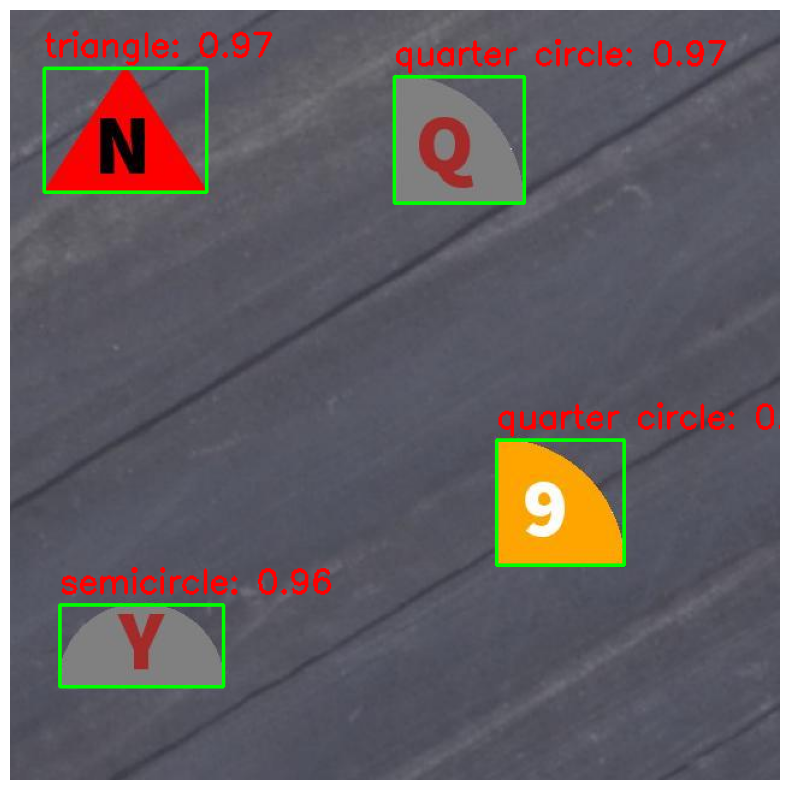

In [16]:
import cv2
import matplotlib.pyplot as plt

# Load the test image
test_img_path = "/kaggle/working/suas-shape-detection-2-2/test/images/00216_jpg.rf.daf2119c76fa3cf2c19f40f18cdfa065.jpg"
test_img = cv2.imread(test_img_path)

# Convert BGR to RGB for displaying correctly with matplotlib
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Get predictions from the model
prediction = model(test_img)
df = prediction.pandas().xyxy[0]

# Iterate through each detected object and draw the bounding boxes
for _, row in df.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    
    # Print bounding box coordinates
    print(f"Bounding box coordinates for {row['name']}: xmin = {xmin}, ymin = {ymin}, xmax = {xmax}, ymax = {ymax}")
    
    # Draw a rectangle around the object
    cv2.rectangle(test_img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green box with thickness 2
    
    # Add label to the bounding box
    label = f"{row['name']}: {row['confidence']:.2f}"
    cv2.putText(test_img_rgb, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Blue text

    # Get real-world coordinates (in meters)
    real_world_x, real_world_y = localize_object(test_img_path, xmin, ymin, xmax, ymax)

    # Convert to latitude and longitude
    latitude, longitude = convert_to_lat_lon(real_world_x, real_world_y)

    print(f"Object: {row['name']}, Coordinates in meters: x = {real_world_x}, y = {real_world_y}")
    print(f"Coordinates in lat/lon: lat = {latitude}, lon = {longitude}")
    print()

# Display the image with bounding boxes using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(test_img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

# Color Classification

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Prepare The Data

In [6]:
# Import the data, and split it

data = pd.read_csv("/kaggle/input/color-classification-11-categories/final_data.csv")
X = data.drop("label", axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<Axes: title={'center': 'Samples per class after resampling'}, xlabel='label'>

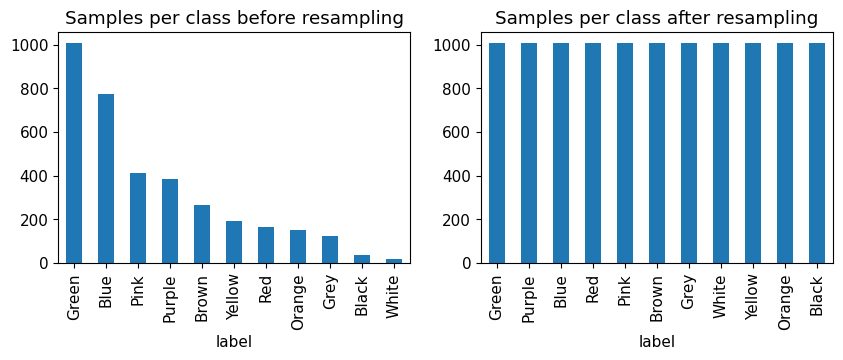

In [7]:
# Fix the imbalance in the dataset

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Samples per class before resampling')

plt.subplot(1, 2, 2)
y_resampled.value_counts().plot(kind='bar', title='Samples per class after resampling')

## KNN Classifier vs Random Forest Classifier

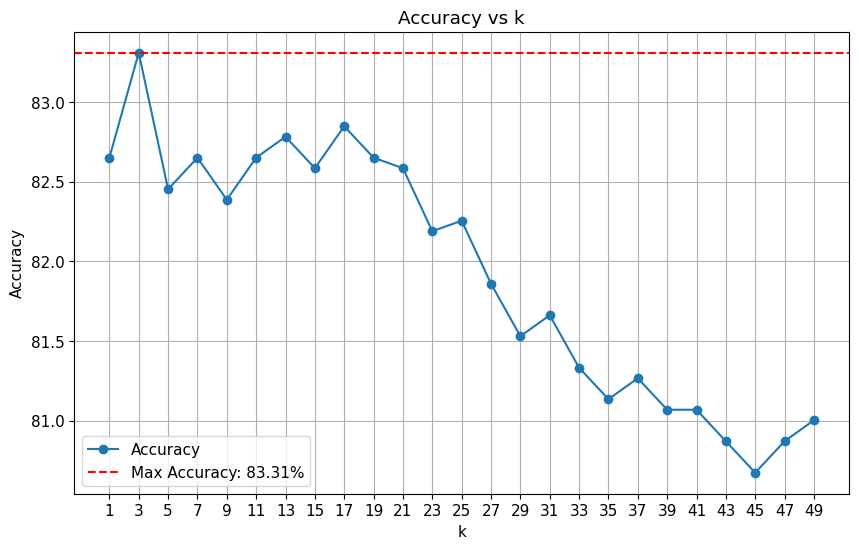

In [20]:
# Test different Ks

accuracies = []
k_range = range(1, 50, 2)

for k in k_range:
    temp_knn = KNeighborsClassifier(n_neighbors=k)
    temp_knn.fit(X_resampled, y_resampled)
    y_pred = temp_knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred) * 100)

plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o', label='Accuracy')

max_accuracy = max(accuracies)
plt.axhline(y=max_accuracy, color='red', linestyle='--', label=f'Max Accuracy: {max_accuracy:.2f}%')

plt.legend()
plt.xticks(k_range)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.grid()
plt.show()

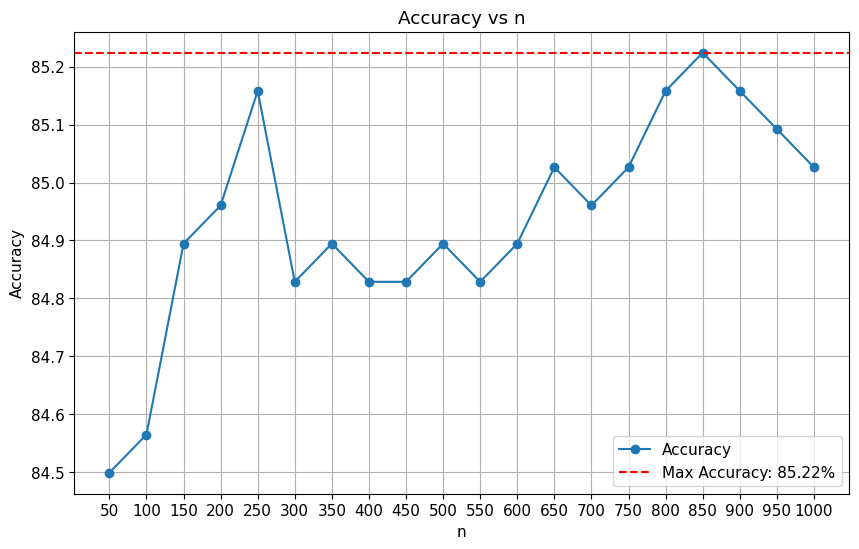

In [17]:
from sklearn.ensemble import RandomForestClassifier

accuracies = []
n_range = range(50, 1050, 50)

for n in n_range:
    rf_clf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_clf.fit(X_resampled, y_resampled)
    y_pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy * 100)

plt.figure(figsize=(10, 6))
plt.plot(n_range, accuracies, marker='o', label='Accuracy')

max_accuracy = max(accuracies)
plt.axhline(y=max_accuracy, color='red', linestyle='--', label=f'Max Accuracy: {max_accuracy:.2f}%')

plt.legend()
plt.xticks(n_range)
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n')
plt.grid()
plt.show()

It can be seen that the random forest classifier results in better accuracies.

## Model

In [18]:
from sklearn.ensemble import RandomForestClassifier

color_classifier = RandomForestClassifier(n_estimators=250, random_state=42)
color_classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=250, random_state=42)

In [9]:
def classify_color(roi):
    freq = dict()
    
    height, width, channels = roi.shape
    
    for y in range(height):
        for x in range(width):
            color = tuple(roi[y, x])

            if freq.get(color):
                freq[color] += 1
            else:
                freq[color] = 1
                
    abundant_color = max(freq, key=freq.get)
    abundant_color = [[abundant_color[2], abundant_color[1], abundant_color[0]]]
    
    return color_classifier.predict(abundant_color)[0]

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


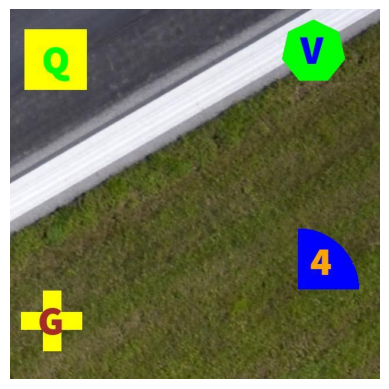

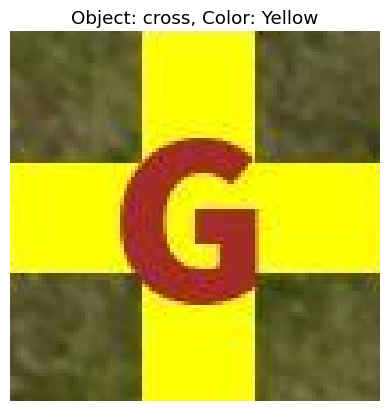

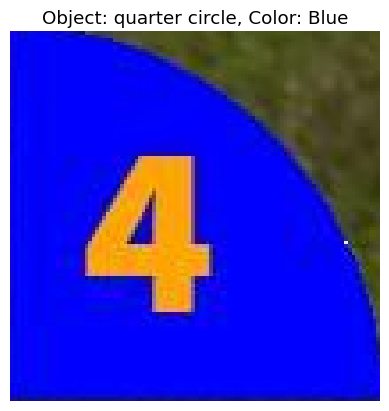

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

test_img_path = "/kaggle/working/suas-shape-detection-2-2/test/images/00019_jpg.rf.0eb7fcfdd4bbb7d1cab1d25e9693f12e.jpg"
test_img = cv2.imread(test_img_path)
    
plt.figure(1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

prediction = model(test_img)
df = prediction.pandas().xyxy[0]

i = 2
for _, row in df.iterrows():
    xmin, ymin, xmax, ymax = round(row['xmin']), round(row['ymin']), round(row['xmax']), round(row['ymax'])
    cropped_img = test_img[ymin:ymax, xmin:xmax]
    
    color = classify_color(cropped_img)
    
    plt.figure(i)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Object: {row['name']}, Color: {color}")
    
    i+=1
    
plt.show()

# OCR (unfinished)

## Experiments

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


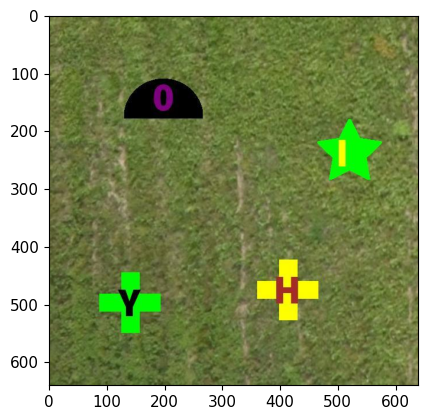

In [29]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

test_img_path = "/kaggle/working/suas-shape-detection-2-2/test/images/00249_jpg.rf.67d9089e684bd2fe6d1c6eb425ea9373.jpg"
test_img = cv2.imread(test_img_path)

results = model(test_img)
df = results.pandas().xyxy[0]

test_images = []
for _, row in df.iterrows():
    xmin, ymin, xmax, ymax = int(round(row['xmin'])), int(round(row['ymin'])), int(round(row['xmax'])), int(round(row['ymax']))
    test_images.append(test_img[ymin:ymax, xmin:xmax])

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

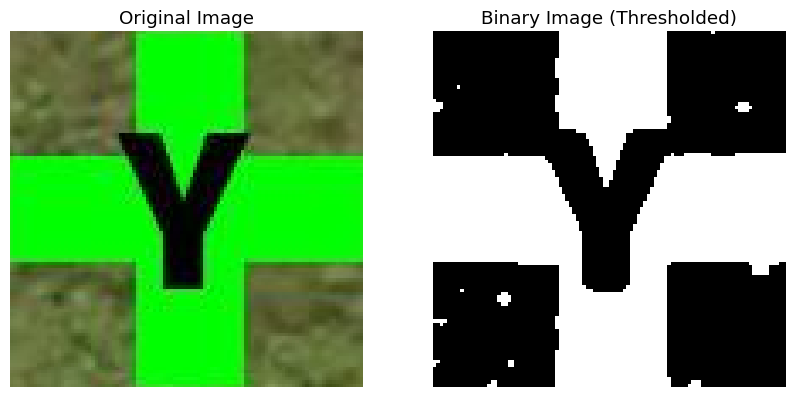

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


image = test_images[0]


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


blurred = cv2.GaussianBlur(gray, (5, 5), 0)


_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


kernel = np.ones((3, 3), np.uint8)
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axis for a cleaner view

# Plot the binary (thresholded) image on the right
axs[1].imshow(binary_cleaned, cmap='gray')  # Display the binary image in grayscale
axs[1].set_title('Binary Image (Thresholded)')
axs[1].axis('off')  # Hide axis for a cleaner view

# Show the images
plt.show()


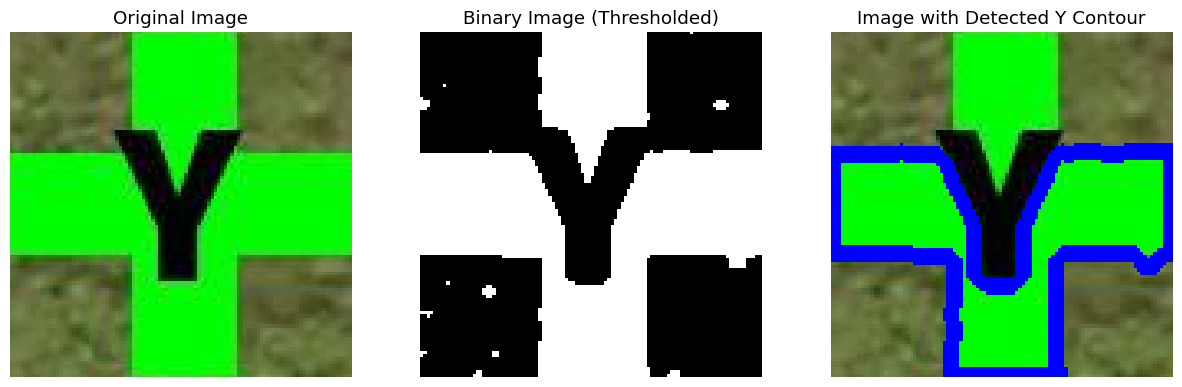

Contour area of detected 'Y': 3498.0


In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image
image = test_images[0]

# 1. Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Apply binary thresholding (Otsu's method for automatic thresholding)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4. Optional: Apply morphological transformations to clean up the binary image
kernel = np.ones((3, 3), np.uint8)
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# 5. Find contours in the binary image
contours, _ = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 6. Draw all contours on the original image (for visualization)
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

# 7. Find the contour corresponding to the "Y" by filtering based on contour area or shape
# Here we use the largest contour as an example (assuming "Y" is the largest shape)
max_contour = max(contours, key=cv2.contourArea)

# 8. Draw only the largest contour (assumed to be the letter "Y")
image_with_y_contour = image.copy()
cv2.drawContours(image_with_y_contour, [max_contour], -1, (255, 0, 0), 3)

# 9. Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Binary Image (Thresholded)
axs[1].imshow(binary_cleaned, cmap='gray')
axs[1].set_title('Binary Image (Thresholded)')
axs[1].axis('off')

# Image with "Y" Contour
axs[2].imshow(cv2.cvtColor(image_with_y_contour, cv2.COLOR_BGR2RGB))
axs[2].set_title('Image with Detected Y Contour')
axs[2].axis('off')

plt.show()

# Optional: You can print the area of the detected contour
print(f"Contour area of detected 'Y': {cv2.contourArea(max_contour)}")


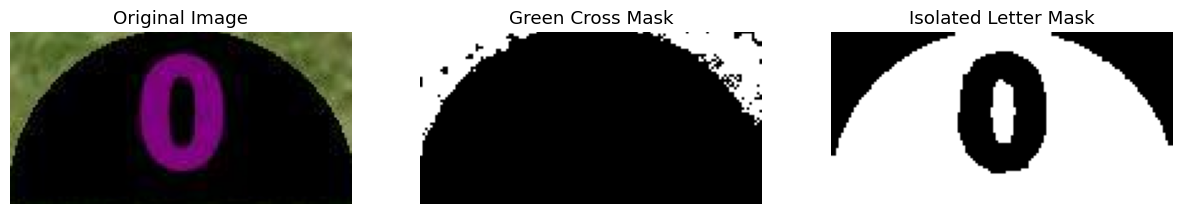

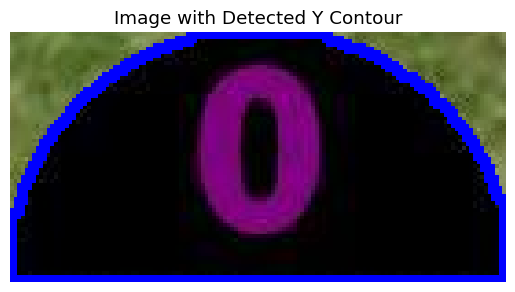

Contour area of detected 'Y': 7340.5


In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


image = test_images[3]


hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


lower_green = np.array([35, 100, 100])
upper_green = np.array([85, 255, 255])
mask_green = cv2.inRange(hsv, lower_green, upper_green)


lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 255, 30])
mask_black = cv2.inRange(hsv, lower_black, upper_black)


letter_mask = cv2.bitwise_and(mask_black, cv2.bitwise_not(mask_green))


kernel = np.ones((3, 3), np.uint8)
letter_mask_cleaned = cv2.morphologyEx(letter_mask, cv2.MORPH_CLOSE, kernel)


contours, _ = cv2.findContours(letter_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')


axs[1].imshow(mask_green, cmap='gray')
axs[1].set_title('Green Cross Mask')
axs[1].axis('off')

axs[2].imshow(letter_mask_cleaned, cmap='gray')
axs[2].set_title('Isolated Letter Mask')
axs[2].axis('off')


plt.show()


plt.imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Y Contour')
plt.axis('off')
plt.show()


if contours:
    max_contour = max(contours, key=cv2.contourArea)
    print(f"Contour area of detected 'Y': {cv2.contourArea(max_contour)}")


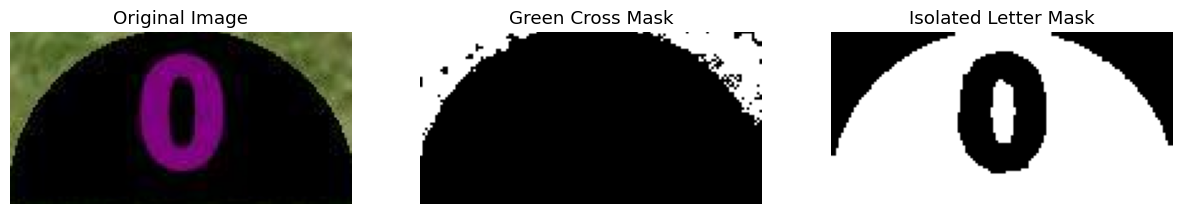

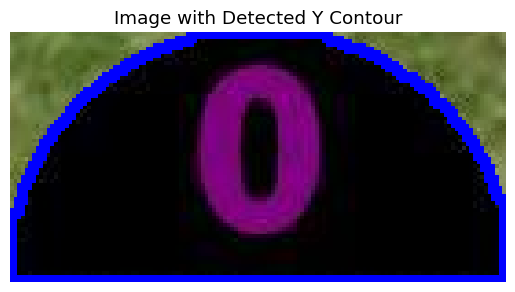

Contour area of detected 'Y': 7340.5


In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


image = test_images[3]


hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


lower_green = np.array([35, 100, 100])
upper_green = np.array([85, 255, 255])
mask_green = cv2.inRange(hsv, lower_green, upper_green)


lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 255, 30])
mask_black = cv2.inRange(hsv, lower_black, upper_black)


letter_mask = cv2.bitwise_and(mask_black, cv2.bitwise_not(mask_green))


kernel = np.ones((3, 3), np.uint8)
letter_mask_cleaned = cv2.morphologyEx(letter_mask, cv2.MORPH_CLOSE, kernel)


contours, _ = cv2.findContours(letter_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')


axs[1].imshow(mask_green, cmap='gray')
axs[1].set_title('Green Cross Mask')
axs[1].axis('off')

axs[2].imshow(letter_mask_cleaned, cmap='gray')
axs[2].set_title('Isolated Letter Mask')
axs[2].axis('off')


plt.show()


plt.imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Y Contour')
plt.axis('off')
plt.show()


if contours:
    max_contour = max(contours, key=cv2.contourArea)
    print(f"Contour area of detected 'Y': {cv2.contourArea(max_contour)}")


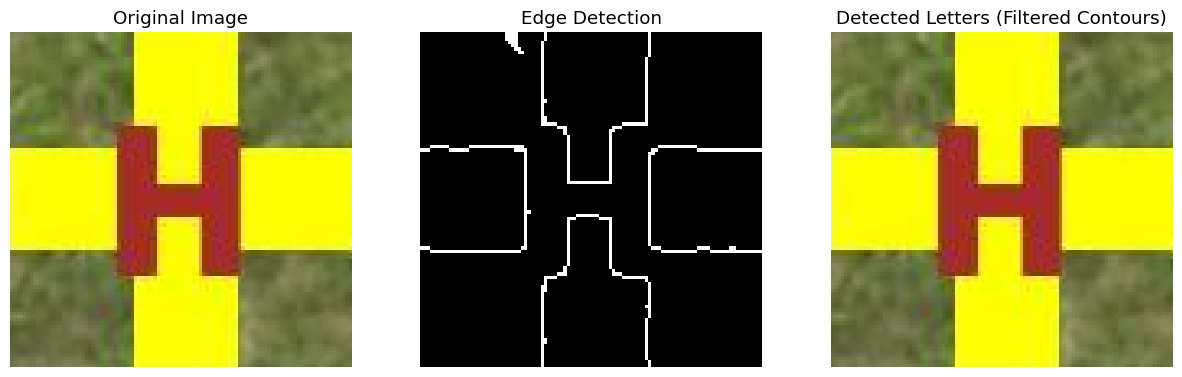

In [36]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image (adjust path if needed)
image = test_images[1]

# 1. Convert to grayscale (ignoring color)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Apply edge detection using Canny to detect sharp changes in intensity
edges = cv2.Canny(blurred, 50, 150)

# 4. Apply morphological transformations to clean up the edges (remove small noise)
kernel = np.ones((3, 3), np.uint8)
cleaned_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# 5. Find contours from the cleaned edge-detected image
contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 6. Draw the detected contours on the original image
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (255, 0, 0), 2)  # Red contours

# 7. Filter contours by area or shape (to focus on potential letter shapes)
filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    # Filter based on area (you can adjust the thresholds based on letter size)
    if 100 < area < 2000:  # Adjust these values based on your letters' size
        filtered_contours.append(contour)

# 8. Draw the filtered contours (likely the letters)
image_with_filtered_contours = image.copy()
cv2.drawContours(image_with_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)  # Green contours for letters

# 9. Display the original image, edge-detected image, and image with detected contours
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Edge-Detected Image
axs[1].imshow(cleaned_edges, cmap='gray')
axs[1].set_title('Edge Detection')
axs[1].axis('off')

# Image with Filtered Contours (letters)
axs[2].imshow(cv2.cvtColor(image_with_filtered_contours, cv2.COLOR_BGR2RGB))
axs[2].set_title('Detected Letters (Filtered Contours)')
axs[2].axis('off')

plt.show()

# Optional: Print area of each filtered contour
for contour in filtered_contours:
    print(f"Contour area: {cv2.contourArea(contour)}")


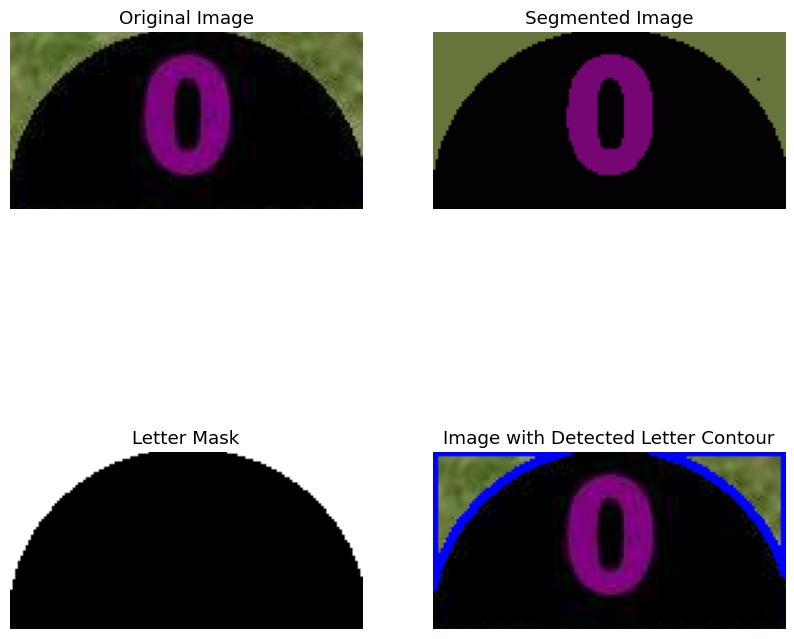

Detected contour area: 729.5
Detected contour area: 782.0


In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image
image = test_images[3]

# 1. Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Reshape the image for K-means clustering
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Define criteria for K-means (stop after 10 iterations or move by less than 1.0)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3  # We segment into 3 clusters: background, shape background, and letter

# 4. Apply K-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 5. Convert the centers back to uint8 and reshape labels
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 6. Convert the segmented image to grayscale for thresholding
segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# 7. Apply thresholding to separate the different regions
_, mask_background = cv2.threshold(segmented_gray, 100, 255, cv2.THRESH_BINARY_INV)
_, mask_shape_background = cv2.threshold(segmented_gray, 150, 255, cv2.THRESH_BINARY)
mask_letter = cv2.bitwise_and(cv2.bitwise_not(mask_background), cv2.bitwise_not(mask_shape_background))

# 8. Apply morphological operations to clean up the masks
kernel = np.ones((3, 3), np.uint8)
mask_letter_cleaned = cv2.morphologyEx(mask_letter, cv2.MORPH_CLOSE, kernel)

# 9. Find contours for the letter
contours, _ = cv2.findContours(mask_letter_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 10. Draw the letter contour on the original image
image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)  # Red contours

# 11. Display the segmented image and the masks
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Segmented Image
axs[0, 1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Segmented Image')
axs[0, 1].axis('off')

# Mask for Letter
axs[1, 0].imshow(mask_letter_cleaned, cmap='gray')
axs[1, 0].set_title('Letter Mask')
axs[1, 0].axis('off')

# Image with Detected Letter Contour
axs[1, 1].imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Image with Detected Letter Contour')
axs[1, 1].axis('off')

plt.show()

# Optional: Print area of the detected contour
for contour in contours:
    print(f"Detected contour area: {cv2.contourArea(contour)}")


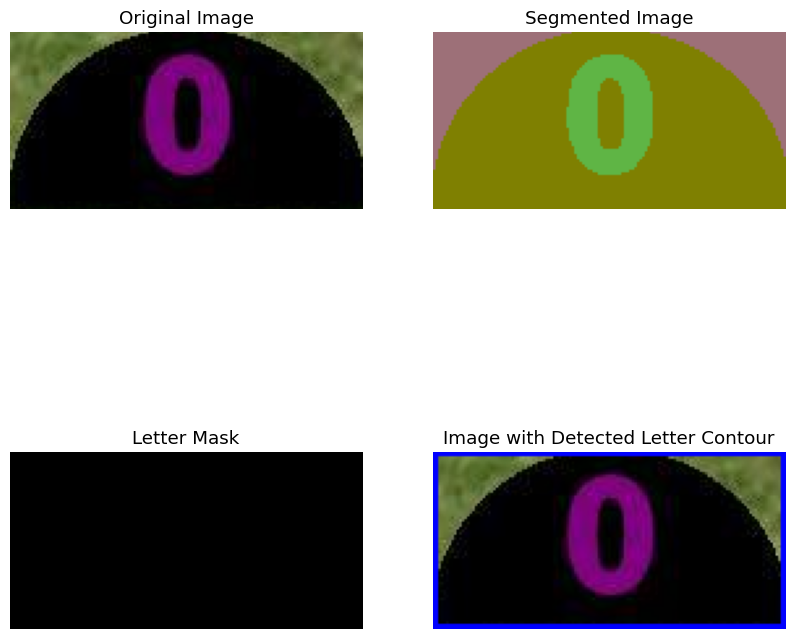

Detected contour area: 8978.0


In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image (adjust path if necessary)
image = test_images[3]

# 1. Convert the image to the LAB color space (to better differentiate between colors)
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# 2. Reshape the image for K-means clustering
pixel_values = lab_image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Define criteria for K-means (stop after 10 iterations or move by less than 1.0)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3

# 4. Apply K-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 5. Convert the centers back to uint8 and reshape labels
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 6. Convert the segmented image to grayscale for thresholding
segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# 7. Apply thresholding to separate the different regions
_, mask_background = cv2.threshold(segmented_gray, 100, 255, cv2.THRESH_BINARY_INV)
_, mask_shape_background = cv2.threshold(segmented_gray, 150, 255, cv2.THRESH_BINARY)
mask_letter = cv2.bitwise_and(cv2.bitwise_not(mask_background), cv2.bitwise_not(mask_shape_background))

# 8. Apply morphological operations to clean up the masks
kernel = np.ones((3, 3), np.uint8)
mask_letter_cleaned = cv2.morphologyEx(mask_letter, cv2.MORPH_CLOSE, kernel)

# 9. Find contours for the letter
contours, _ = cv2.findContours(mask_letter_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 10. Draw the letter contour on the original image
image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)  # Red contours

# 11. Display the segmented image and the masks
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Segmented Image
axs[0, 1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Segmented Image')
axs[0, 1].axis('off')

# Mask for Letter
axs[1, 0].imshow(mask_letter_cleaned, cmap='gray')
axs[1, 0].set_title('Letter Mask')
axs[1, 0].axis('off')

# Image with Detected Letter Contour
axs[1, 1].imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Image with Detected Letter Contour')
axs[1, 1].axis('off')

plt.show()

# Optional: Print area of the detected contour
for contour in contours:
    print(f"Detected contour area: {cv2.contourArea(contour)}")


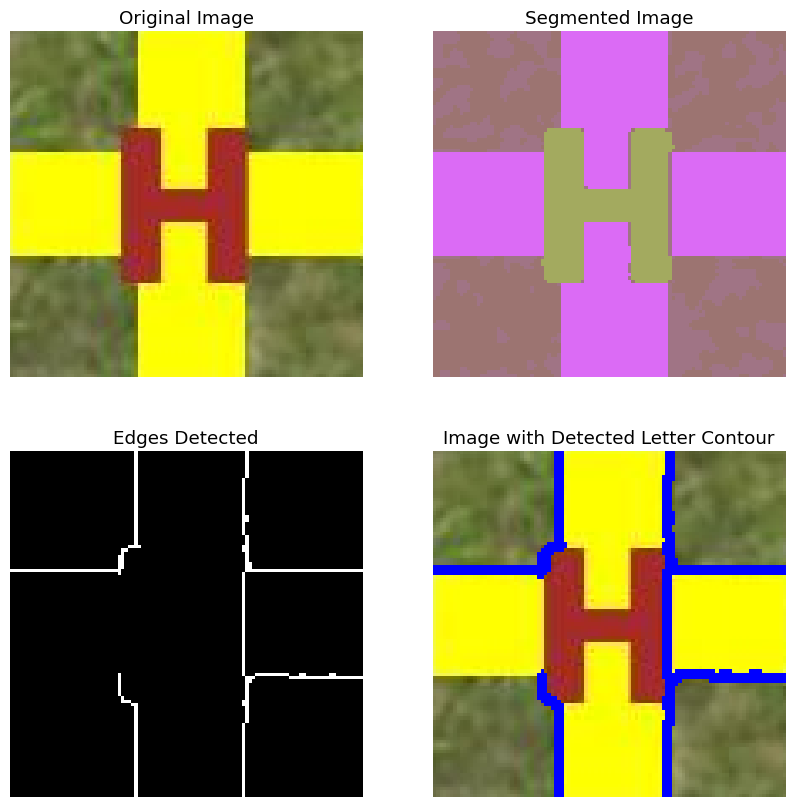

Detected contour area: 1.0
Detected contour area: 15.0
Detected contour area: 6.5


In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image
image = test_images[1]

# 1. Convert the image to the LAB color space for better color separation
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# 2. Reshape the image for K-means clustering
pixel_values = lab_image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Define criteria for K-means clustering and increase clusters (e.g., k=4)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 4  # Increased clusters to better segment background, shape, and letter
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 4. Convert the centers back to uint8 and reshape labels
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 5. Convert the segmented image to grayscale for edge detection
segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# 6. Apply edge detection to better isolate the letter
edges = cv2.Canny(segmented_gray, 50, 150)

# 7. Apply morphological operations to close gaps in the detected edges
kernel = np.ones((3, 3), np.uint8)
edges_cleaned = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# 8. Find contours based on the cleaned edges
contours, _ = cv2.findContours(edges_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 9. Draw the detected letter contours on the original image
image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)  # Red contours

# 10. Display the segmented image and the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Segmented Image
axs[0, 1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Segmented Image')
axs[0, 1].axis('off')

# Edge Detection Result
axs[1, 0].imshow(edges_cleaned, cmap='gray')
axs[1, 0].set_title('Edges Detected')
axs[1, 0].axis('off')

# Image with Detected Letter Contour
axs[1, 1].imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Image with Detected Letter Contour')
axs[1, 1].axis('off')

plt.show()

# Optional: Print the area of detected contours
for contour in contours:
    print(f"Detected contour area: {cv2.contourArea(contour)}")


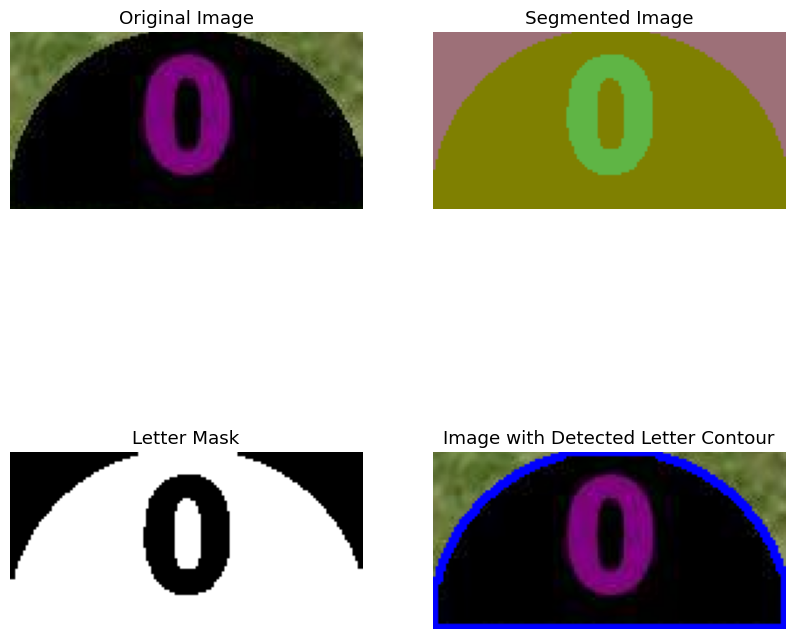

Detected contour area: 7347.5


In [40]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image (adjust path if necessary)
image = test_images[3]

# 1. Convert the image to the LAB color space (better for segmentation)
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# 2. Reshape the image for K-means clustering
pixel_values = lab_image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Define criteria for K-means clustering and set k=3 to segment the image into 3 distinct regions
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3  # Cluster into background, shape, and letter
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 4. Convert the centers back to uint8 and reshape labels to get the segmented image
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 5. Analyze the segmented image:
# Identify different color regions based on unique center values
unique_colors = np.unique(segmented_image.reshape(-1, 3), axis=0)

# Create masks for each unique color (representing each region)
masks = {}
for i, color in enumerate(unique_colors):
    mask = cv2.inRange(segmented_image, color, color)  # Mask for the current color region
    masks[f"region_{i}"] = mask

# 6. Select the mask corresponding to the letter (assuming one of the regions represents the letter)
# You can adjust which region corresponds to the letter based on your specific image analysis
letter_mask = masks['region_0']  # This can be region_0, region_1, or region_2 depending on the color

# 7. Clean up the mask using morphological transformations (if needed)
kernel = np.ones((3, 3), np.uint8)
letter_mask_cleaned = cv2.morphologyEx(letter_mask, cv2.MORPH_CLOSE, kernel)

# 8. Find contours in the letter mask
contours, _ = cv2.findContours(letter_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 9. Draw the detected letter contours on the original image
image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)  # Red contours for the letter

# 10. Display the segmented image, mask, and final image with the letter contour
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Segmented Image
axs[0, 1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Segmented Image')
axs[0, 1].axis('off')

# Mask for the letter region
axs[1, 0].imshow(letter_mask_cleaned, cmap='gray')
axs[1, 0].set_title('Letter Mask')
axs[1, 0].axis('off')

# Image with Detected Letter Contour
axs[1, 1].imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Image with Detected Letter Contour')
axs[1, 1].axis('off')

plt.show()

# Optional: Print the area of detected contours
for contour in contours:
    print(f"Detected contour area: {cv2.contourArea(contour)}")


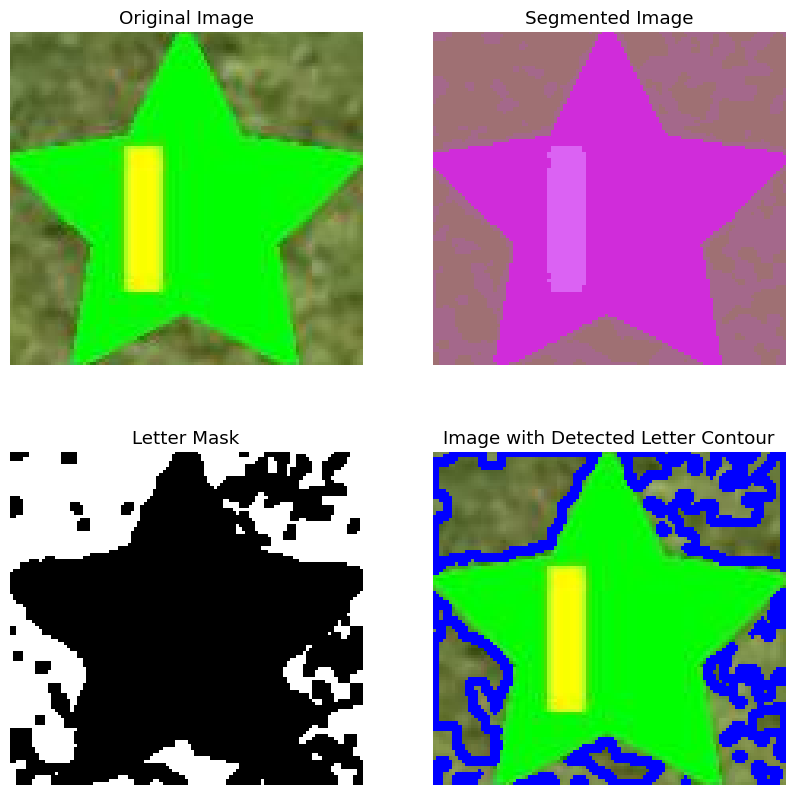

Detected contour area: 0.0
Detected contour area: 2.0
Detected contour area: 10.5
Detected contour area: 9.5
Detected contour area: 0.0
Detected contour area: 23.5
Detected contour area: 12.0
Detected contour area: 1.5
Detected contour area: 174.0
Detected contour area: 105.5
Detected contour area: 104.5
Detected contour area: 0.0
Detected contour area: 665.5
Detected contour area: 35.5
Detected contour area: 2.0
Detected contour area: 7.5
Detected contour area: 573.5
Detected contour area: 51.0
Detected contour area: 109.0
Detected contour area: 1295.0


In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the original image (adjust path if necessary)
image = test_images[2]

# 1. Convert the image to the LAB color space (better for segmentation)
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# 2. Reshape the image for K-means clustering
pixel_values = lab_image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Define criteria for K-means clustering and set k=3 to segment the image into 3 distinct regions
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 4  # Increase clusters to separate letter, shape, background, etc.
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 4. Convert the centers back to uint8 and reshape labels to get the segmented image
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 5. Analyze the segmented image:
# Identify different color regions based on unique center values
unique_colors = np.unique(segmented_image.reshape(-1, 3), axis=0)

# Create masks for each unique color (representing each region)
masks = {}
for i, color in enumerate(unique_colors):
    mask = cv2.inRange(segmented_image, color, color)  # Mask for the current color region
    masks[f"region_{i}"] = mask

# 6. Select the mask corresponding to the letter (manually select the correct mask)
# You can adjust which region corresponds to the letter based on your specific image analysis
letter_mask = masks['region_0']  # Adjust 'region_0', 'region_1', etc., depending on which is the letter

# 7. Clean up the mask using morphological transformations (if needed)
kernel = np.ones((3, 3), np.uint8)
letter_mask_cleaned = cv2.morphologyEx(letter_mask, cv2.MORPH_CLOSE, kernel)

# 8. Find contours in the letter mask
contours, _ = cv2.findContours(letter_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 9. Draw the detected letter contours on the original image
image_with_letter_contour = image.copy()
cv2.drawContours(image_with_letter_contour, contours, -1, (255, 0, 0), 2)  # Red contours for the letter

# 10. Display the segmented image, mask, and final image with the letter contour
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Segmented Image
axs[0, 1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Segmented Image')
axs[0, 1].axis('off')

# Mask for the letter region
axs[1, 0].imshow(letter_mask_cleaned, cmap='gray')
axs[1, 0].set_title('Letter Mask')
axs[1, 0].axis('off')

# Image with Detected Letter Contour
axs[1, 1].imshow(cv2.cvtColor(image_with_letter_contour, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Image with Detected Letter Contour')
axs[1, 1].axis('off')

plt.show()

# Optional: Print the area of detected contours
for contour in contours:
    print(f"Detected contour area: {cv2.contourArea(contour)}")


## EasyOCR

In [17]:
import easyocr

reader = easyocr.Reader(['en'])

def detect_alphanumeric(roi):
    ocr_results = reader.readtext(roi)
    if ocr_results:
        return ocr_results[0][-2]  # Return the detected text
    return "None"

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


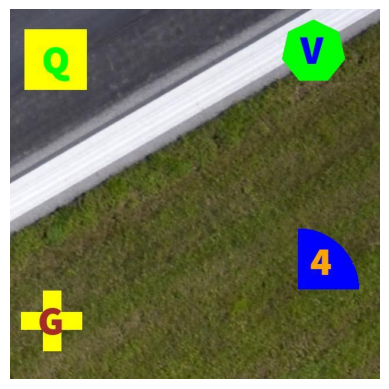

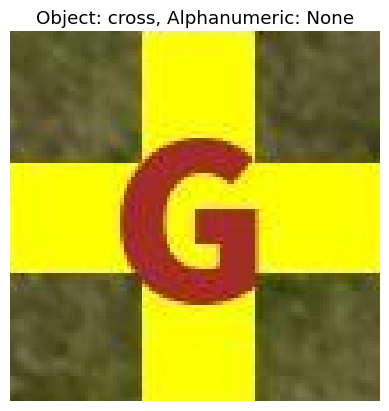

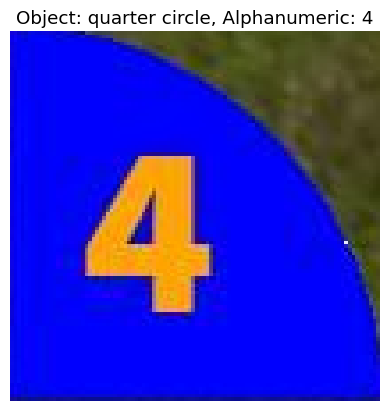

In [19]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

test_img_path = "/kaggle/working/suas-shape-detection-2-2/test/images/00019_jpg.rf.0eb7fcfdd4bbb7d1cab1d25e9693f12e.jpg"
test_img = cv2.imread(test_img_path)
    
plt.figure(1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

prediction = model(test_img)
df = prediction.pandas().xyxy[0]

i = 2
for _, row in df.iterrows():
    xmin, ymin, xmax, ymax = round(row['xmin']), round(row['ymin']), round(row['xmax']), round(row['ymax'])
    cropped_img = test_img[ymin:ymax, xmin:xmax]
    
    alphanumeric = detect_alphanumeric(cropped_img)

    plt.figure(i)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Object: {row['name']}, Alphanumeric: {alphanumeric}")
    
    i+=1
    
plt.show()